In [1]:
import numpy as np
import modin.pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline

from sklearn.utils import shuffle
import sys
import cv2


import scipy as sp
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import StandardScaler


Using TensorFlow backend.


In [2]:
Xy_crop_df=pd.read_csv('saved/Xy_crop.csv',index_col=0)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(Xy_crop_df.iloc[:,:3072].values,
                                                Xy_crop_df.label.values,
                                                stratify=Xy_crop_df.label.values)

In [5]:
scaler = StandardScaler() 
scaler.fit(X_train)  
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

Now that we are ready, we will use the following to find the best classifier:
* Random Forest
* Neural Network

We will try a few strategies to improve the performance of the models:
* Address the imbalance in the dataset
* Image augmentation
* hyperparameter tuning

In [6]:
#Random Forest
# Create the model with 100 trees

model = RandomForestClassifier(verbose=1,n_jobs=-1)
# Fit on training data
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

Classification Report (test):


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


              precision    recall  f1-score   support

           0       0.76      0.88      0.82     32727
           1       0.77      0.59      0.67     22280

    accuracy                           0.76     55007
   macro avg       0.77      0.74      0.74     55007
weighted avg       0.76      0.76      0.76     55007

Confusion Matrix:


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


[[28818  3909]
 [ 9094 13186]]


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


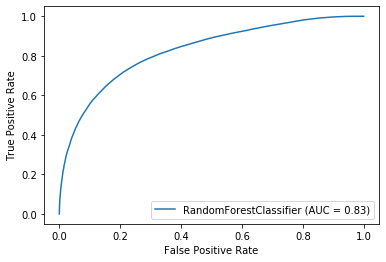

In [7]:
print('Classification Report (test):')
print(classification_report(y_test,model.predict(X_test)))
print('Confusion Matrix:')
print(confusion_matrix(y_test,model.predict(X_test)))
plot_roc_curve(model,X_test,y_test)
plt.show()

In [8]:

model = MLPClassifier(early_stopping=True)
model.fit(X_train, y_train)

2min 1s ± 12.6 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


Classification Report (test):
              precision    recall  f1-score   support

           0       0.76      0.88      0.82     32727
           1       0.77      0.59      0.67     22280

    accuracy                           0.76     55007
   macro avg       0.77      0.74      0.74     55007
weighted avg       0.76      0.76      0.76     55007

Confusion Matrix:
[[28818  3909]
 [ 9094 13186]]


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


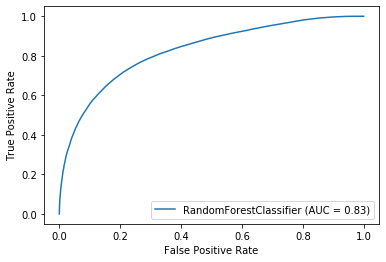

In [9]:
pred=model.predict(X_test)
print('Classification Report (test):')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(model,X_test,y_test)
plt.show()

We can see that the neural net isn't getting better results. At this point I would like to examine why. Two factors immediately are apparent:
* The dataset is imbalanced
* Perhaps some image augmentation would help


Let's tacke the imbaance first. We'll try the simplest strategy, a random undersampling of the majority class. The overall set is 220000 images so there will still be enough to train the classifier even after dropping We'll use a reduced set of 30000 of them. For the sake of time let's test with a reduced set first then scale up to the entire dataset once improvements are established.

In [ ]:

rus=RandomUnderSampler()
X_res,y_res=rus.fit_resample(Xy_crop_df.iloc[:,:3072].values, Xy_crop_df.label.values)


In [ ]:
X_discard, X_small, y_discard, y_small=train_test_split(X_res,y_res,stratify=y_res,test_size=0.15,random_state=42)

In [ ]:
print(len(y_small[y_small==1]))
print(len(y_small[y_small==0]))

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_small,y_small,stratify=y_small,test_size==0.25,random_state=42)

Now that we have a smaller, balanced set, let's see if we gained anything. We'll try the same neural net as before.

In [ ]:
scaler = StandardScaler() 
scaler.fit(X_train)  
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

In [9]:
model = RandomForestClassifier(n_jobs=-1)
# Fit on training data
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Classification Report (test):
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      3342
           1       0.78      0.72      0.75      3342

    accuracy                           0.76      6684
   macro avg       0.76      0.76      0.76      6684
weighted avg       0.76      0.76      0.76      6684

Confusion Matrix:
[[2677  665]
 [ 942 2400]]


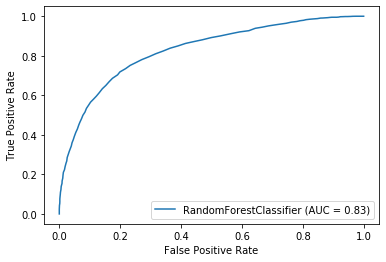

In [10]:
print('Classification Report (test):')
print(classification_report(y_test,model.predict(X_test)))
print('Confusion Matrix:')
print(confusion_matrix(y_test,model.predict(X_test)))
plot_roc_curve(model,X_test,y_test)
plt.show()

In [11]:
model = MLPClassifier(early_stopping=True)
model.fit(X_train, y_train)

17.7 s ± 4.9 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Classification Report (test):
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      3342
           1       0.78      0.72      0.75      3342

    accuracy                           0.76      6684
   macro avg       0.76      0.76      0.76      6684
weighted avg       0.76      0.76      0.76      6684

Confusion Matrix:
[[2677  665]
 [ 942 2400]]


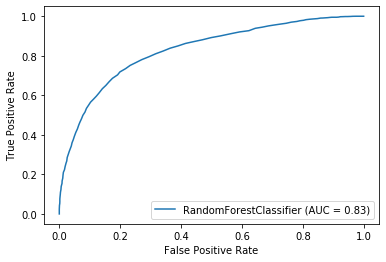

In [12]:
pred=model.predict(X_test)
print('Classification Report (test):')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(model,X_test,y_test)
plt.show()

### image augmentation with imgaug


In [14]:
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import imgaug as ia


In [15]:
#make the same train-test split, we need pre-normalized images for augmentation
X_train,X_test,y_train,y_test=train_test_split(X_small,y_small,stratify=y_small,random_state=42)

Many transformations assume the images are in the normal shape (3-d array) so we're going to reshape the images back to that shape first

In [16]:
#reshape the images
X_train=X_train.reshape((X_train.shape[0],32,32,3))

In [17]:
X_test=X_test.reshape((X_test.shape[0],32,32,3))

In [18]:
X_train[0].shape

(32, 32, 3)

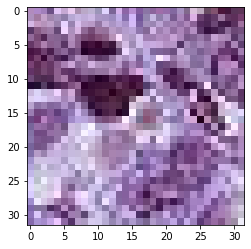

In [19]:
plt.imshow(X_test[0])
plt.show()

In [20]:
X_train=X_train.astype(np.uint8)
X_test=X_test.astype(np.uint8)

since we don't have a good idea which augmentations may improve the classification, we'll use a pipeline of several

In [21]:
# Define an augmentation pipeline
aug_pipeline = iaa.Sequential([
    # apply one of the augmentations: Dropout or CoarseDropout
    iaa.OneOf([
        iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
        iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
    ]),
    # apply from 0 to 3 of the augmentations from the list
    iaa.SomeOf((0, 3),[
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
        iaa.Fliplr(1.0), # horizontally flip
        iaa.Sometimes(0.5, iaa.Affine(rotate=5)) # rotate 50% of the images
    ]),
    iaa.OneOf([
        iaa.contrast.LogContrast(gain=(1.2,1.4),per_channel=True)
    ])
],
random_order=True # apply the augmentations in random order
)

In [22]:
# Apply augmentation pipeline to the test and train sets
X_train = np.array([aug_pipeline.augment_image(each) for each in X_train])
X_test =  np.array([aug_pipeline.augment_image(each) for each in X_test])

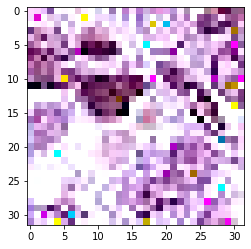

In [23]:
plt.imshow(X_test[0])
plt.show()

In [24]:
#flatten the images and scale them
X_train=np.array([each.flatten() for each in X_train])
X_test=np.array([each.flatten() for each in X_test])

In [25]:
scaler = StandardScaler() 
scaler.fit(X_train)  
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

In [26]:
%%timeit
model = MLPClassifier(early_stopping=True)
model.fit(X_train, y_train)

18.2 s ± 2.63 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Classification Report (test):
              precision    recall  f1-score   support

           0       0.58      0.64      0.61      2228
           1       0.60      0.54      0.57      2228

    accuracy                           0.59      4456
   macro avg       0.59      0.59      0.59      4456
weighted avg       0.59      0.59      0.59      4456

Confusion Matrix:
[[1430  798]
 [1026 1202]]


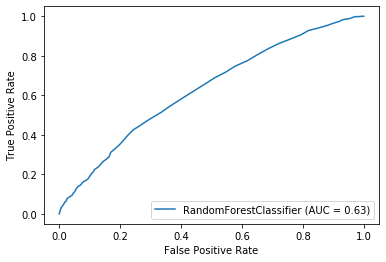

In [27]:
pred=model.predict(X_test)
print('Classification Report (test):')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(model,X_test,y_test)
plt.show()

Adding a few augmentations at random causes a slight degradation in performance. If we simply increase the contrast we may have better luch:

In [28]:
#make the same train-test split, we need pre-normalized images for augmentation
X_train,X_test,y_train,y_test=train_test_split(X_small,y_small,stratify=y_small,random_state=42)

In [29]:
#reshape the images
X_train=X_train.reshape((X_train.shape[0],32,32,3)).astype(np.uint8)
X_test=X_test.reshape((X_test.shape[0],32,32,3)).astype(np.uint8)

In [30]:
# Define an augmentation pipeline
aug_pipeline = iaa.Sequential([
 
    iaa.OneOf([
        iaa.contrast.LogContrast(gain=(1.2,1.4),per_channel=True)
    ])
],
random_order=True # apply the augmentations in random order
)

In [31]:
# Apply augmentation pipeline to the test and train sets
X_train = np.array([aug_pipeline.augment_image(each) for each in X_train])
X_test =  np.array([aug_pipeline.augment_image(each) for each in X_test])

In [32]:
#flatten the images and scale them
X_train=np.array([each.flatten() for each in X_train])
X_test=np.array([each.flatten() for each in X_test])

In [33]:
scaler = StandardScaler() 
scaler.fit(X_train)  
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

In [10]:
model = MLPClassifier(early_stopping=True)
model.fit(X_train, y_train)

The slowest run took 4.82 times longer than the fastest. This could mean that an intermediate result is being cached.
23.9 s ± 14.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
pred=model.predict(X_test)
print('Classification Report (test):')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(model,X_test,y_test)
plt.show()

NameError: name 'model' is not defined

Since improvement is minimal, we will leave image augmentation aside for now and proceed with the unaltered data.

#### Hyperparameter tuning

In [ ]:
#make the same train-test split, we need pre-normalized images for augmentation
X_train,X_test,y_train,y_test=train_test_split(X_small,y_small,stratify=y_small,random_state=42)

In [7]:
scaler = StandardScaler() 
scaler.fit(X_train)  
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

First we'll find the best parameters for the random forest

In [ ]:


#parameters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 3000, num = 6)]
max_features = ['sqrt','log2']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True]
criterion = ['entropy']

params={'n_estimators': n_estimators,
        'max_features': max_features,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap,
        'criterion': criterion}

In [ ]:
rfc=RandomForestClassifier()

rf_rand=RandomizedSearchCV(estimator=rfc, 
                           param_distributions=params, 
                           cv=2,
                           verbose=1, 
                           n_jobs=-1,
                           return_train_score=True)
rf_rand.fit(X_test,y_test)
rf_rand.best_params_

In [40]:
rf_rand.best_params_

{'n_estimators': 2420,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'criterion': 'entropy',
 'bootstrap': True}

In [13]:
#now plug best parameters into the random forest
model = RandomForestClassifier(n_estimators=2420,
                               min_samples_split=10,
                               min_samples_leaf=2,
                               max_features='log2',
                               criterion='entropy',
                               bootstrap=True,
                               verbose=1,
                               n_jobs=-1)
# Fit on training data
model.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2420 out of 2420 | elapsed:  3.9min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=2420,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 2420 out of 2420 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Classification Report (test):
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      3342
           1       0.76      0.76      0.76      3342

    accuracy                           0.76      6684
   macro avg       0.76      0.76      0.76      6684
weighted avg       0.76      0.76      0.76      6684

Confusion Matrix:
[[2516  826]
 [ 795 2547]]


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 2420 out of 2420 | elapsed:    3.1s finished


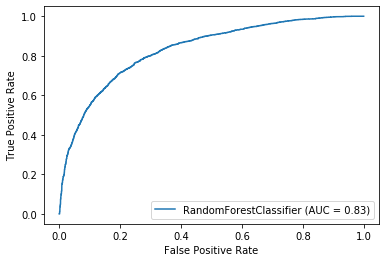

In [14]:
pred=model.predict(X_test)
print('Classification Report (test):')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(model,X_test,y_test)
plt.show()

So tuning the parameters yields a small improvement to the random forest. This appears to be the best we'll do with this classifier. Let's use the same strategy to tune the nerual net.

In [25]:
#parameters for neural net
hidden_layer_sizes = [(1536,),
                      (1536,768,)]
solver = ['sgd']
activation = ['logistic']
#max_iter = [50,200,500]
learning_rate = ['adaptive']
learning_rate_init = [.0001,.001,.01,.1]
beta_1=(.2,.5,.9)
beta_2=(.5,.9,.98,.999)
#random_state = [1,2,3,4,5]

params={'hidden_layer_sizes' : hidden_layer_sizes,
        'solver' : solver,
        'activation' : activation,
        'learning_rate' : learning_rate,
        'learning_rate_init' : learning_rate_init,
        'beta_1' : beta_1,
        'beta_2' : beta_2               
        }


In [27]:
mlp=MLPClassifier(early_stopping=True,warm_start=True)
mlp_rand=RandomizedSearchCV(estimator=mlp,
                            param_distributions=params,
                            n_iter=90,
                            cv=2,
                            verbose=1,
                            n_jobs=-1,
                            return_train_score=True
                            )
mlp_rand.fit(X_test,y_test)
print(mlp_rand.best_params_)

Fitting 2 folds for each of 90 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 142.1min finished


{'solver': 'sgd', 'learning_rate_init': 0.1, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (1536, 768), 'beta_2': 0.9, 'beta_1': 0.2, 'activation': 'logistic'}


In [28]:
mlp_rand.best_params_

{'solver': 'sgd',
 'learning_rate_init': 0.1,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (1536, 768),
 'beta_2': 0.9,
 'beta_1': 0.2,
 'activation': 'logistic'}

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(1536, 768,),
                      early_stopping=True,
                      solver = 'sgd',
                      learning_rate_init = 0.1,
                      random_state = 4,
                      learning_rate = 'adaptive',
                      beta_1 = 0.1,
                      beta_2= 0.8,
                      activation = 'logistic')
model.fit(X_train, y_train)

In [ ]:
pred=model.predict(X_test)
print('Classification Report (test):')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(model,X_test,y_test)
plt.show()

Let's see how these perform on the whole dataset, again with balancing by undersampling of the majority class.

In [3]:

rus=RandomUnderSampler()
X_res,y_res=rus.fit_resample(Xy_crop_df.iloc[:,:3072].values, Xy_crop_df.label.values)


In [5]:
#confirm the classes are balanced
print(len(y_res[y_res==1]))
print(len(y_res[y_res==0]))

89117
89117


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_res,
                                                    y_res,
                                                    stratify=y_res)

In [6]:
scaler = StandardScaler() 
scaler.fit(X_train)  
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

In [7]:

model = MLPClassifier(early_stopping=True,hidden_layer_sizes=(100,))
model.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Classification Report (test):
              precision    recall  f1-score   support

           0       0.75      0.71      0.73     22280
           1       0.72      0.77      0.74     22279

    accuracy                           0.74     44559
   macro avg       0.74      0.74      0.74     44559
weighted avg       0.74      0.74      0.74     44559

Confusion Matrix:
[[15738  6542]
 [ 5209 17070]]


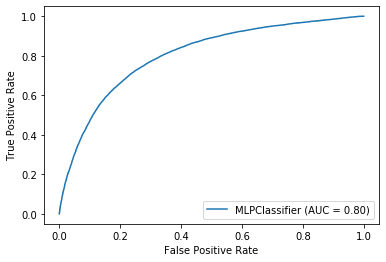

In [8]:
pred=model.predict(X_test)
print('Classification Report (test):')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(model,X_test,y_test)
plt.show()

In [40]:
#now plug best parameters into the random forest
model = RandomForestClassifier(n_estimators=2420,
                               min_samples_split=10,
                               min_samples_leaf=2,
                               max_features='log2',
                               criterion='entropy',
                               bootstrap=True,
                               verbose=1,
                               n_jobs=-1)
# Fit on training data
model.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 2420 out of 2420 | elapsed:  7.7min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=2420,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    3.8s
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:    5.5s
[Parallel(n_jobs=16)]: Done 2420 out of 2420 | elapsed:    7.5s finished


Classification Report (test):
              precision    recall  f1-score   support

           0       0.76      0.77      0.76     22280
           1       0.76      0.75      0.76     22279

    accuracy                           0.76     44559
   macro avg       0.76      0.76      0.76     44559
weighted avg       0.76      0.76      0.76     44559

Confusion Matrix:
[[17084  5196]
 [ 5473 16806]]


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    3.8s
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:    5.5s
[Parallel(n_jobs=16)]: Done 2420 out of 2420 | elapsed:    7.5s finished


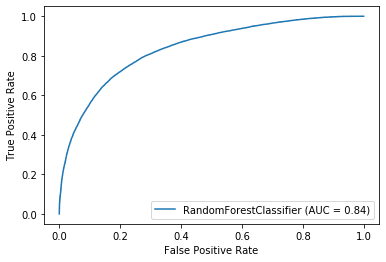

In [41]:
pred=model.predict(X_test)
print('Classification Report (test):')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(model,X_test,y_test)
plt.show()

It looks like the best results are a slight improvement on the Random Forest classifier. To yield this small improvement, we balanced the dataset by undersampling the majority class, and tuned the hyperparameters using a Randomized Search cross-validation. These yielded a slight improvement in performance, e.g. an improvement on the AUC from 0.80 to 0.84. I think we are nearing the limit of these strategies when applied to this dataset. For better performance we can usse something like a convolutional neural net, but that is beyond the scope of this notebook.